In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm

from sklearn.metrics import mean_squared_error as MSE

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme()

/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
data = pd.read_csv("leinhardt.csv")

data = data[data["infant"].isna() == False]

data["loginfant"] = np.log(data["infant"])
data["logincome"] = np.log(data["income"])

Scale the predictors as suggested by Gelman, Hill in Data Analysis Using Regression and Multilevel/Hierarchical Models (2006)

In [3]:
def scaler(X:np.array):

    stddev = np.std(X)
    mean = np.mean(X)

    return (X - mean) / (2*stddev)

y = np.log(data["infant"].to_numpy())
x = scaler(np.log(data["income"].to_numpy()))

data["scaledincome"] = x

oil, oil_value = pd.factorize(data["oil"])
region, region_name = pd.factorize(data["region"])

<AxesSubplot:xlabel='logincome', ylabel='loginfant'>

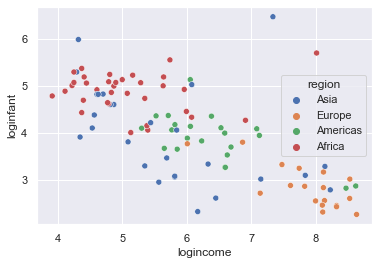

In [4]:
sns.scatterplot(data=data, x="logincome", y="loginfant", hue="region")

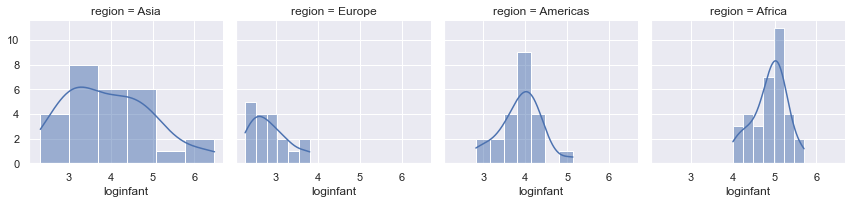

In [5]:
g = sns.FacetGrid(data, col="region")
g.map(sns.histplot, "loginfant", kde=True)

## Complete Pooling - no difference between regions
A regression against all the regions together

In [6]:
with pm.Model() as model_regression:

    beta_0 = pm.Normal("beta_0", mu=0, sigma=10)
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)

    sigma = pm.Gamma("sigma", mu=2, sigma=2)

    predicted = beta_0 + beta_1 * x + beta_2 * oil

    obs = pm.Normal("obs", mu=predicted, sigma=sigma, observed=y)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_90348/877226722.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_regression = pm.sample(2000, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_2, beta_1, beta_0]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a 

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 40 seconds.


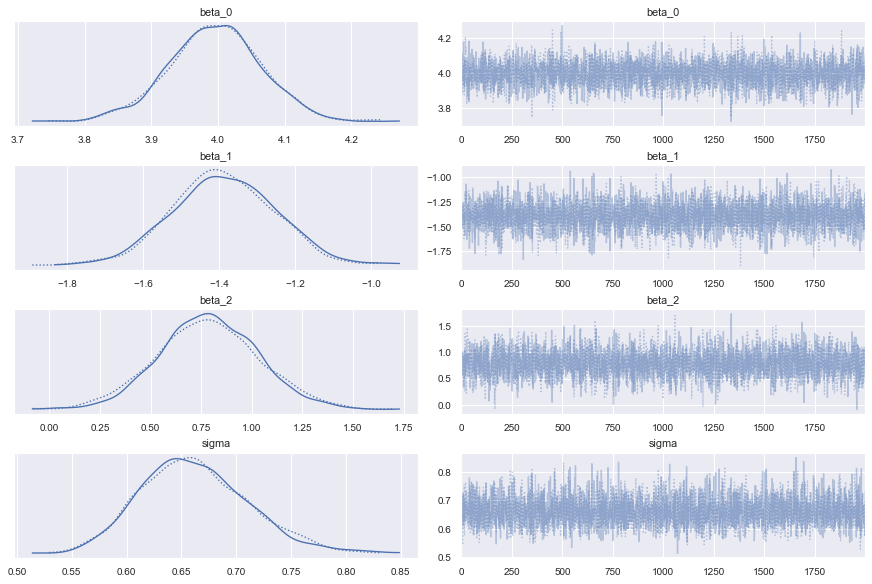

In [7]:
with model_regression:
    trace_regression = pm.sample(2000, target_accept=0.95)
    pm.plot_trace(trace_regression)

## No Pooling
An independent regression for each region

In [8]:
with pm.Model() as model_region:

    alpha = pm.Normal("alpha", mu=0, sigma=10, shape=len(region_name))
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10, shape=len(region_name))

    error = pm.Exponential("error", 1)

    obs = pm.Normal("obs", mu=alpha[region] + beta_1[region] * x, sigma=error, observed=y)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_90348/158195017.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_region = pm.sample(2000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [error, beta_1, alpha]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 60 seconds.


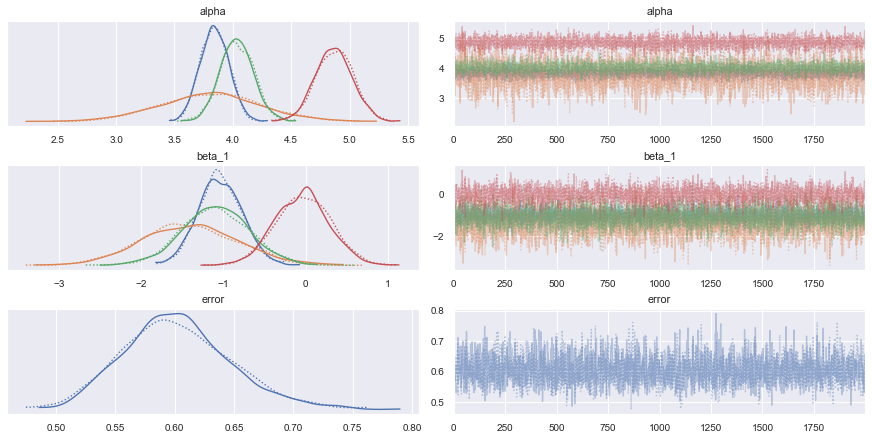

In [9]:
with model_region:
    trace_region = pm.sample(2000)
    pm.plot_trace(trace_region)

In [10]:
with pm.Model() as model_heirarchical:

    theta_a = pm.Normal("theta_a", mu=0, sigma=10)
    sigma_a = pm.Gamma("sigma_a", mu=2, sigma=2)
    a_ = pm.Normal("a_", mu=0, sd=1, shape=len(region_name))
    
    alpha = pm.Deterministic("alpha", theta_a + a_ * sigma_a)
    
    beta_1 = pm.Normal("beta_1", mu=0, sigma=10)
    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)

    resp = alpha[region] + beta_1 * x + beta_2 * oil

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_90348/3221333165.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_heirarchical = pm.sample(6000, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, beta_2, beta_1, a_, sigma_a, theta_a]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compressio

Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 390 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 54 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


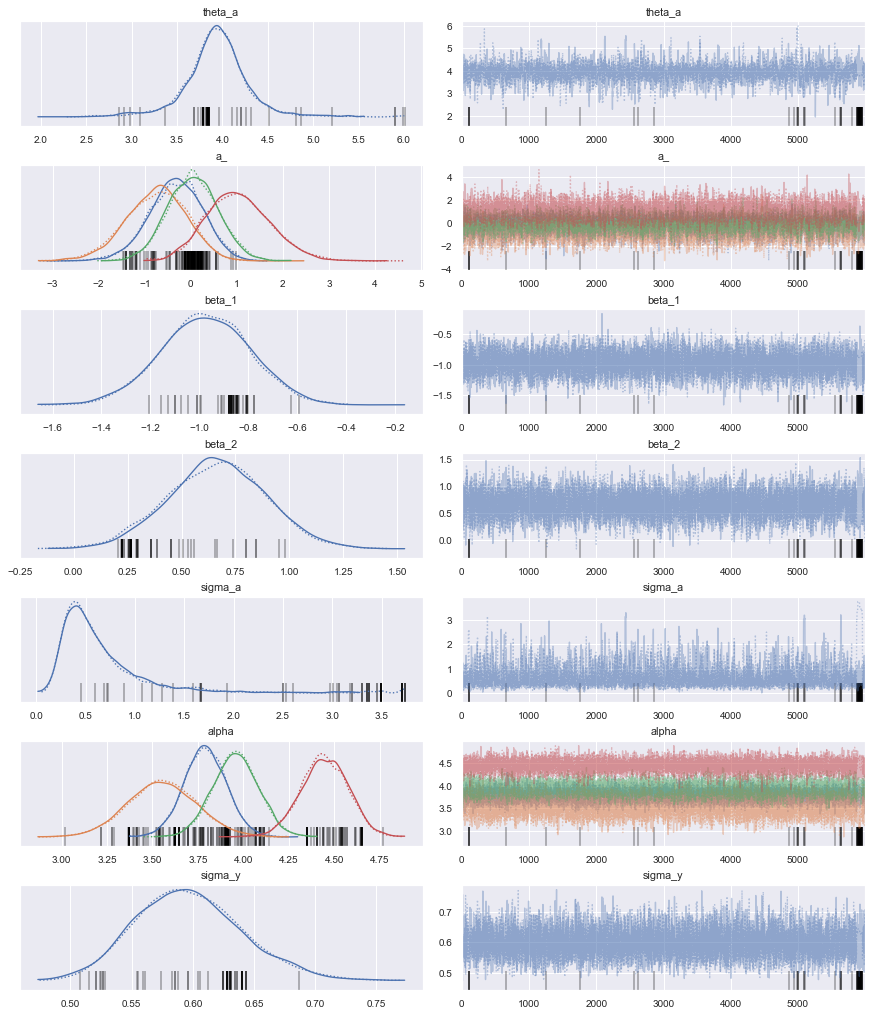

In [11]:
with model_heirarchical:
    trace_heirarchical = pm.sample(6000, target_accept=0.95)
    pm.plot_trace(trace_heirarchical)

In [12]:
with pm.Model() as model_vary_slopes:

    theta_a = pm.Normal("theta_a", mu=0, sigma=10)
    sigma_a = pm.Gamma("sigma_a", mu=2, sigma=2)
    a_ = pm.Normal("a_", mu=0, sd=1, shape=len(region_name))
    
    theta_b = pm.Normal("theta_b", mu=0, sigma=10)
    sigma_b = pm.Gamma("sigma_b", mu=2, sigma=2)
    b_ = pm.Normal("b_", mu=0, sd=1, shape=len(region_name))


    alpha = pm.Deterministic("alpha", theta_a + a_ * sigma_a)
    beta_1 = pm.Deterministic("beta_1", theta_b + b_ * sigma_b)

    beta_2 = pm.Normal("beta_2", mu=0, sigma=10)

    resp = alpha[region] + beta_1[region] * x + beta_2 * oil

    sigma_y = pm.Exponential("sigma_y", 1)

    obs = pm.Normal("obs", mu=resp, sigma=sigma_y, observed=y)

/var/folders/j1/pk1lddxj0d73lw8z0g6dpfph0000gn/T/ipykernel_90348/1401794436.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_vary_slopes = pm.sample(6000, target_accept=0.95)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_y, beta_2, b_, sigma_b, theta_b, a_, sigma_a, theta_a]
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/btb/.virtualenvs/prml/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lz

Sampling 2 chains for 1_000 tune and 6_000 draw iterations (2_000 + 12_000 draws total) took 374 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


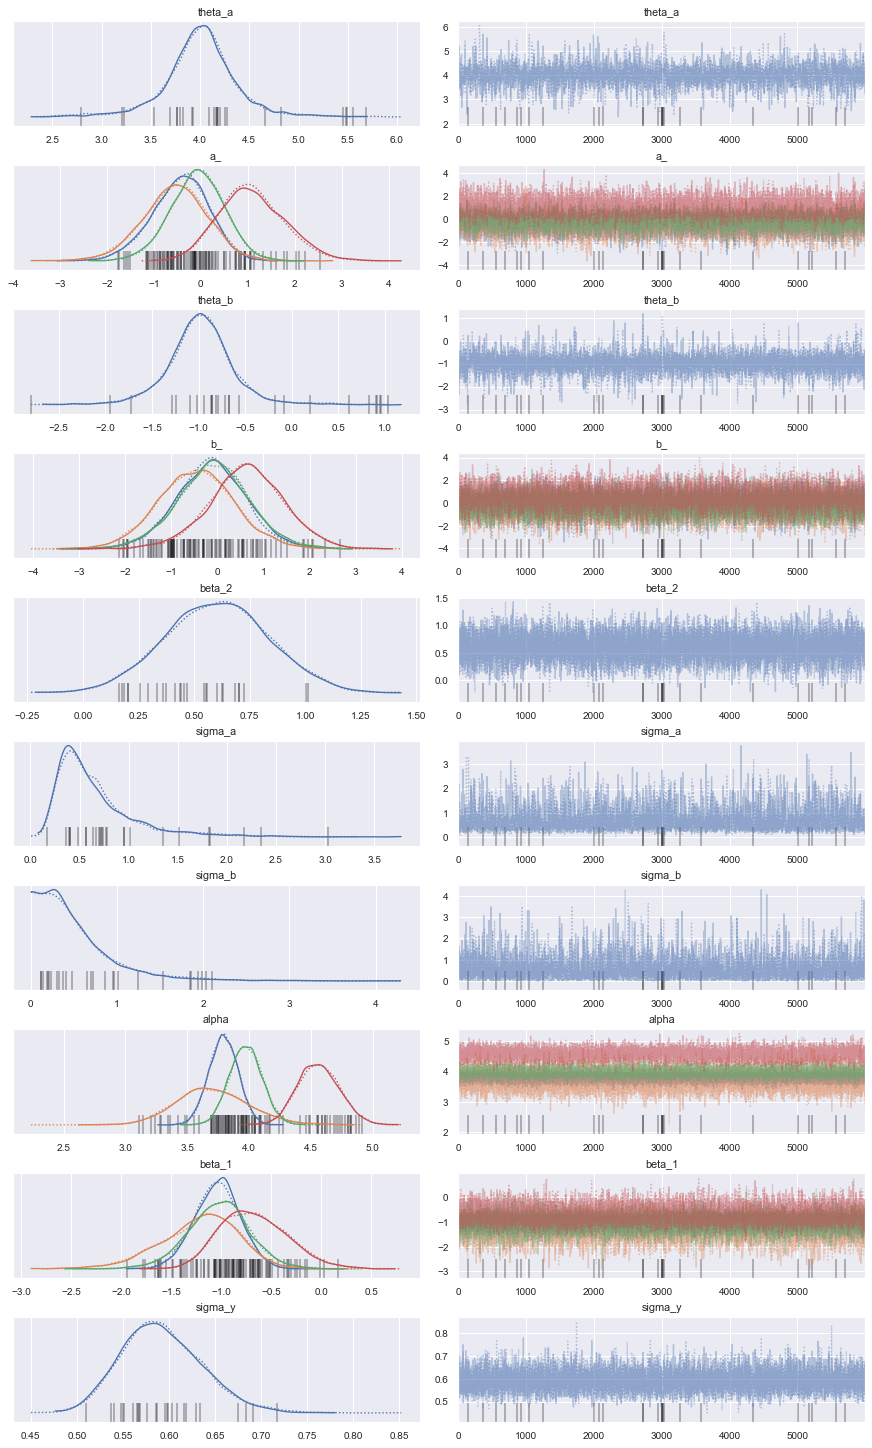

In [13]:
with model_vary_slopes:
    trace_vary_slopes = pm.sample(6000, target_accept=0.95)
    pm.plot_trace(trace_vary_slopes)

In [14]:
with model_regression:
    regression_obs = pm.sample_posterior_predictive(trace_regression)
with model_region:
    region_obs = pm.sample_posterior_predictive(trace_region)
with model_heirarchical:
    heirarchical_obs = pm.sample_posterior_predictive(trace_heirarchical)
with model_vary_slopes:
    vary_slopes_obs = pm.sample_posterior_predictive(trace_vary_slopes)

In [15]:
print("Regression Model:                      {:.5f}".format(MSE(y, regression_obs["obs"].mean(axis=0))))
print("Region Model:                          {:.5f}".format(MSE(y, region_obs["obs"].mean(axis=0))))
print("Region Heirarchical Model:             {:.5f}".format(MSE(y, heirarchical_obs["obs"].mean(axis=0))))
print("Varying Slopes Model:                  {:.5f}".format(MSE(y, vary_slopes_obs["obs"].mean(axis=0))))

Regression Model:                      0.41524
Region Model:                          0.32629
Region Heirarchical Model:             0.32937
Varying Slopes Model:                  0.31604


In [16]:
alphas = np.median(trace_vary_slopes["alpha"], axis=0)
betas = np.median(trace_vary_slopes["beta_1"], axis=0)

regression_a = np.median(trace_regression["beta_0"], axis=0)
regression_b = np.median(trace_regression["beta_1"], axis=0)

alphas_region = np.median(trace_region["alpha"], axis=0)
betas_region = np.median(trace_region["beta_1"], axis=0)

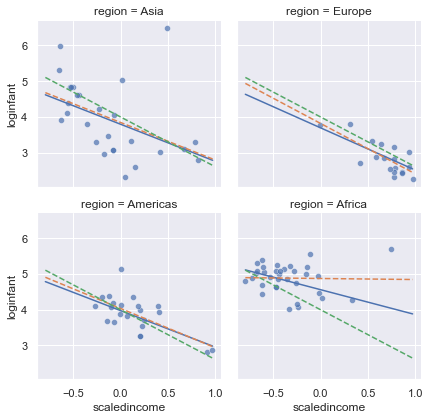

In [17]:
x_ = np.linspace(np.min(x), np.max(x))

g = sns.FacetGrid(data, col="region", col_wrap=2)
g.map(sns.scatterplot, "scaledincome", "loginfant", alpha=.7)
g.add_legend()

for ax, alpha_, beta_ in zip(g.axes_dict.values(), alphas, betas):
    y_ = alpha_ + beta_ * x_
    ax.plot(x_,y_)


for ax, alpha_, beta_ in zip(g.axes_dict.values(), alphas_region, betas_region):
    y_ = alpha_ + beta_ * x_
    ax.plot(x_,y_, linestyle='--')

for ax in g.axes_dict.values():
    y_ = regression_a + regression_b * x_
    ax.plot(x_,y_, '--')

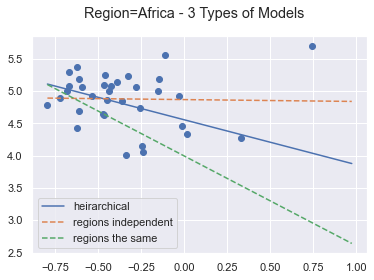

In [18]:
x_plot = data[data["region"] == "Africa"]["scaledincome"]
y_plot = data[data["region"] == "Africa"]["loginfant"]

fig, ax = plt.subplots()
fig.suptitle("Region=Africa - 3 Types of Models")

ax.scatter(x_plot, y_plot)

y_ = alphas[3] + betas[3] * x_
ax.plot(x_,y_, label="heirarchical")

y_ = alphas_region[3] + betas_region[3] * x_
ax.plot(x_,y_, linestyle='--', label="regions independent")

y_ = regression_a + regression_b * x_
ax.plot(x_,y_, linestyle='--', label="regions the same")

ax.legend()

In [19]:
y_hat = np.mean(vary_slopes_obs["obs"], axis=0)
data["residual"] = y - y_hat

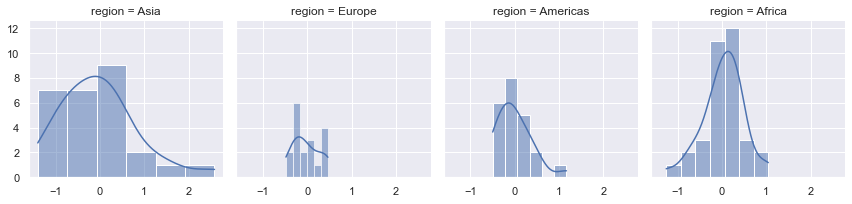

In [20]:
g = sns.FacetGrid(data, col="region")
g.map_dataframe(sns.histplot, x="residual", kde=True)